# JOINs and UNIONs

**1. Introduction**

In the intro to SQL micro-course, you learned how to use INNER JOIN to consolidate information from two different tables. Now you'll learn about a few more types of JOIN, along with how to use UNIONs to pull information from multiple tables.

Along the way, we'll work with two imaginary tables, called owners and pets.

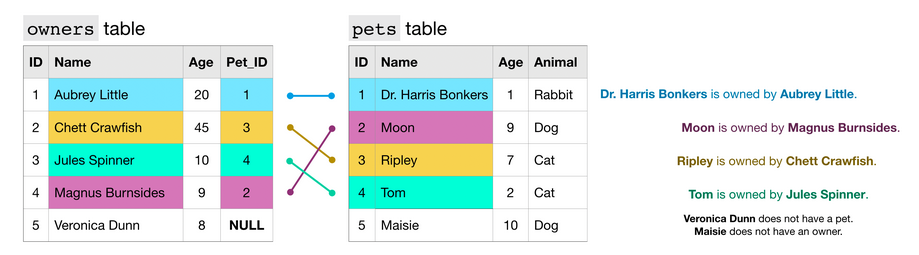

Each row of the owner table identifies a pet owner, where the ID column is a unique identifier. The Pet_ID column (in the owners table) conatains the ID for the pet that belongs to the owner (this number matches the ID for the pet from the pets table).

For example, 

- the pets table shows that Dr.Harris Bonker is the pet with ID 1.
- The owner table shows that Aubery Little is the owner of the pet with ID1. 

Putting these two facts togheter, Dr.Harris Bonkers is owneb by Aubery Little. Likewise, since Veronica Dunn does not have a corresponding Pet_ID, she does not have a pet. And, since 5 does not appear in the Pet_ID column, Maisie does not have an owner. 


**2. JOINs**

Recall that we an use an INNER JOIN to pull rows from both tables where the value in the PET_ID column in the owners table has a match in the ID column of the pets table. 

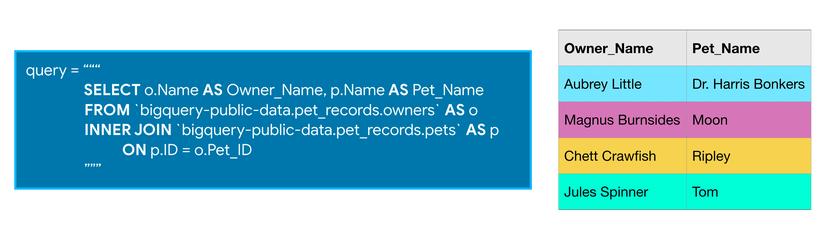

In this case, Veronica Dunn and Maisie are not included in the results. But what if we instead want to create a table containing all pets, regardless of whether they have owner? Or, what if we want to combine all of the rows in both tables? In these cases, we need only use a different type of JOIN.

For instance, to create a table containing all rows from the owners table, we usea LEFT JOIN. In this case, "left" refers to the table that appears before the JOIN in the query. ("Right" refers to the table that is after the JOIN.)

Replacing INNER JOIN in the uqery above with LEFT JOIN returns all rows where the two tables matching entries, along with all of the rows in the left table (whether there is a match or not). 

If we instead use a RIGHT JOIN, we get the matching rows, along with all rows in the right table (whether there is a match or not).

Finally a FULL JOIN returns all rows from both tables. Note that in general, any row that does not have a match in both tables will have NULL entries for the missing values. You can see this in the image below. 

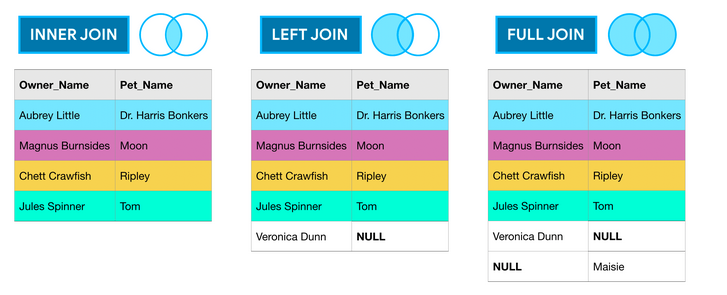


**3. UNIONS**

As you've seen, JOINs horizontally combines results from different tables. If you instead would like to vertically concatenate columns, you can do so with a UNION. The example query below combines the Age columns from both tables. 

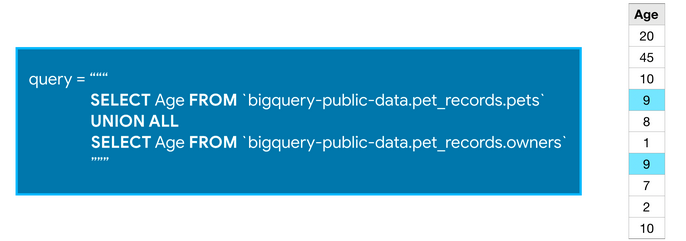

Note that with a UNION, the data types of both columns must be the same, but the columns names can be different. (So, for instance, we cannot take the UNION of the ge column from the owners table and the Pet_Name column from the pets table.)

We use UNION ALL to include duplicated values - you'll notice that 9 appeas in both the owners table and the pets table, and shows up twice in the concatenated results. If you'd like to drop duplicate values, you need only change UNION ALL in the query to UNION DISTINCT.

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

# Construct a reference to the "stories" table

table_ref = dataset_ref.table("stories")

# API - request - fetch the table

table = client.get_table(table_ref)

# Preview the first five lines of the table

client.list_rows(table, max_results=5).to_dataframe()

In [1]:
# Query to select all stories posted on January 1, 2012, with number of comments

job_query = """
            WITH c AS
            (
            SELECT parent, COUNT(*) AS num_comments
            FROM `bigquery-public-data.hacker_news.comments`
            GROUP BY parent
            )
            SELECT s.id AS story_id, s.by, s.title, c.num_comments
            FROM `bigquery-public-data.hacker_news.stories` AS s 
            LEFT JOIN c
            ON s.id = c.parent
            WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
            ORDER BY c.num_comments DESC
            """

# Run the query, and return a pandas DataFrame

join_result = client.query(job_query).result().to_dataframe()

# Analytic Functions

**1. Introduction**

In the intro to SQL micro-course, you learned how to use aggregate functions, which perform calculations based on sets of rows. In this tutorial, you'll learn how to define analytic functions, which also operate on a set of rows. However, unlike aggregate functions, analytic functions return a (potentially different) value for each row in the original table.

Analytic functions allow us to perform complex calculations with relatively straightfoward syntax. For instance, we can quickly calculate moving averages and running totals, among other quantities.


**2. Syntax**

To understand how to write analytic functions, we'll work with a small  table containing data from two different people who are training for a race. The id column identifies each runner, the date column holds the day of the training session, and time shows the time (in minutes) that the runner dedicated to training. Say we'd like to calculate a moving agerage of the training times for each runner, where we always take the average of the current and previous training sessions. 

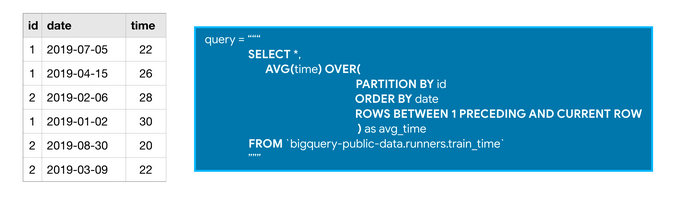

All analytic functions have an 'OVER' clause, which defines the sets of rows used in each calculation. The 'OVER' cluase has three (optional) part :

- The PARTIION BY cluase divides the rows of table into different groups. In the query above, we divide by id so that the calculation are separated by runner.
- The ORDER BY cluase defines an ordering within each partition. In the sample query, ordering by the data column ensures that earlier training sessions appear first.
- The final cluase ( ROWS BETWEEN 1 PREDCIDING AND CURRENT ROW ) is known as a window frame cluase. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. 

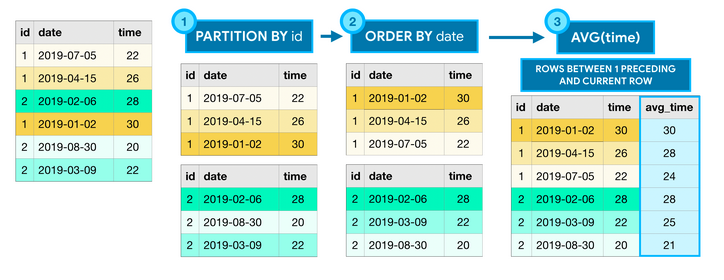

**3. (More on) window frame cluase**

There are many ways to write window frame cluases : 
- ROWS BETWEEN 1 PRECEDING AND CURRENT ROW : the previous row and the current row.
- ROWS BETWEEN 3 PRECIDING AND 1 FOLLOWING : the 3 previous rows, the current row, the following row.
- ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING : all rows in the partition

Of course, this is not an exhaustive list, and you can imagine that there are many more options! 

**4. Three types of analytic functions**

The example above uses only one of many analytic functions. BigQuery supports a wide variety of analytic functions, and we'll explore a few here.

1) Analytic aggregate functions  
As you might recall, AVG() (from the example above) is an aggregate function. The OVER cluase is what ensures that it's treated as an analytic (aggregate) function. Aggregate functions take all of the values within the window as input and return a single value. 

- MIN() or MAX() : returns the minimum of input values
- AVG() or SUM() : returns the average of input values
- COUNT() : returns the number of rows in the input

2) Analytic navigation functions  
Navigation functions assign a value based on the value in a different row than the current row. 
- FIRST_VALUE() or LAST_VALUE() : returns the first/last value in the input
- LEAD() or LAG() : returns the value on a subsequent/preceding row 

3) Analytic numbering functions  
Numbering functions assign integer values to each row based on the ordering.
- ROW_NUMBER() : returns the order in which rows appear in the input
- RANK() : all rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe() 

In [ ]:
# Calculate the cumulative number of trips for each date in 2015.

num_trips_query = """
                  WITH trip_by_day AS
                      (
                      SELECT DATE(start_date) AS trip_date, 
                          COUNT(*) as num_trips
                      FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                      WHERE EXTRACT(YEAR FROM start_date) = 2015
                      GROUP BY trip_date
                      )
                      SELECT *, 
                          SUM(num_trips)
                              OVER (
                                   ORDER BY trip_date
                                   ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                                   ) AS cumulative_trips
                          FROM trip_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

The query uses a common table expression (CTE) to first calculate the daily number of trips. Then, we use SUM() as an aggregate function. 

- Since there is no PARTITION BY clause, the entire table is treated as a single partition.
- The ORDER BY cluase orders the rows by date, where earlier dates appear first
- By setting the window frame cluase to ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW, we ensure that all rows up to and including the vurrent date are used to calculate the (cumulative) sum. 

In [ ]:
# Tracks the stations where each bike began and ended the day on October 25, 2015.

# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()



The query uses both FIRST_VALUE() and LAST_VALUE() as analytic functions.
- The PARTITION BY cluase breaks the data into partitions based on the bike_number coumns. Since this column holds unique identifiers for bikes, this ensures the calculation are performed separately for each bike.
- The ORDER BY cluase puts the rows within each partition in chronological order.
- Since the window frame clause is ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING, for each row, its entire partition is used to perform the calculation.

# Nested and Repeated Data

# Writing Efficient Queries